In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..', 'validate_assay'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pcrvalidationtools import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [3]:
# Files 
DATA_PATH = "../Data/v4_08262024/"
datasets_file = DATA_PATH + 'ev_metadata_filtered.tsv'
assay1_file = DATA_PATH + 'ev_db/' + 'assay0.tsv'
assay2_file = DATA_PATH + 'ev_db/' + 'assay8.tsv'
assay3_file = DATA_PATH + 'ev_db/' + 'assay1.tsv'
assay4_file = DATA_PATH + 'ev_db/' + 'assay2.tsv'
collapse_taxonomy_file = DATA_PATH + 'ev_taxonomy_collapse.tsv'

In [4]:
# Retreive enterovirus, taxonomy group data
ev_data = pd.read_csv(datasets_file, sep='\t')
collapse_info = pd.read_csv(collapse_taxonomy_file, sep='\t')

# Get metadata for expected positive assay hits 
assay1 = assess_data(ev_data, get_accessions(assay1_file)) 
assay2 = assess_data(ev_data, get_accessions(assay2_file)) 
assay3 = assess_data(ev_data, get_accessions(assay3_file)) 
assay4 = assess_data(ev_data, get_accessions(assay4_file)) 

# Inputs 
assays = [assay1, assay2, assay3, assay4]
assay_names = ['Assay 1', 'Assay 2', 'Assay 3', 'Assay 4']
years = [2000, 2005, 2010, 2015, 2020, 2024]
virus_order = ['Enterovirus A', 'Enterovirus B', 'Enterovirus C', 'Enterovirus D', 
       'Rhinovirus A', 'Rhinovirus B', 'Rhinovirus C', 'unclassified Rhinovirus']

Combined summary for all assays 

In [5]:
summarize_assays(assays, assay_names, collapse_info)

Virus Group   TaxID  Assay 1 Hits  Assay 2 Hits  Assay 3 Hits  \
0            Enterovirus A  138948          1513          1510          1508   
1            Enterovirus B  138949           453           448           448   
2            Enterovirus C  138950           997           999           950   
3            Enterovirus D  138951             6             6             6   
4             Rhinovirus A  147711             0             0             0   
5             Rhinovirus B  147712             0             0             0   
6             Rhinovirus C  463676             6             0             0   
7  unclassified Rhinovirus  348531             0             0             0   

   Assay 4 Hits  Total  
0          1500   1522  
1           467    468  
2          1006   1007  
3           537    537  
4           158    684  
5             5    118  
6            65    339  
7             0      1

Collection timeplots for all assays

In [6]:
ev_taxids = collapse_info[collapse_info['Collapse Name'].str.contains('Enterovirus')]['Virus Taxonomic ID'].unique()

In [7]:
# Remove enterovirus data 
ev_taxids = collapse_info[collapse_info['Collapse Name'].str.contains('Enterovirus')]['Virus Taxonomic ID'].unique()
filtered_assays = [assay[assay['Virus Taxonomic ID'].isin(ev_taxids)] for assay in assays]

# Generate cumulative counts over time (collection and release year)  
all_year_counts = [count_years(assay_data) for assay_data in filtered_assays]
all_cumulative_counts = [make_cumulative(year_counts) for year_counts in all_year_counts]

# Retrieve collection data 
all_collection = [separate_year_types(cumulative_counts)[0] for cumulative_counts in all_cumulative_counts]

# Rename count column to assay name 
all_collection = [df.rename(columns={'Hit':assay_name}) for df, assay_name in zip(all_collection, assay_names)]

In [8]:
# Combine collection data for all assays 
combined = all_collection[0]
for df in all_collection[1:]:
    combined = combined.join(df[df.columns[1]])
combined

Total  Assay 1  Assay 2  Assay 3  Assay 4
Collection Year                                            
1955                3.0      3.0      2.0      2.0      3.0
1956                3.0      3.0      2.0      2.0      3.0
1957                3.0      3.0      2.0      2.0      3.0
1958                3.0      3.0      2.0      2.0      3.0
1959                3.0      3.0      2.0      2.0      3.0
...                 ...      ...      ...      ...      ...
2020             3349.0   2869.0   2862.0   2811.0   3325.0
2021             3368.0   2887.0   2880.0   2829.0   3344.0
2022             3472.0   2908.0   2901.0   2850.0   3448.0
2023             3528.0   2963.0   2957.0   2906.0   3504.0
2024             3534.0   2969.0   2963.0   2912.0   3510.0

[70 rows x 5 columns]

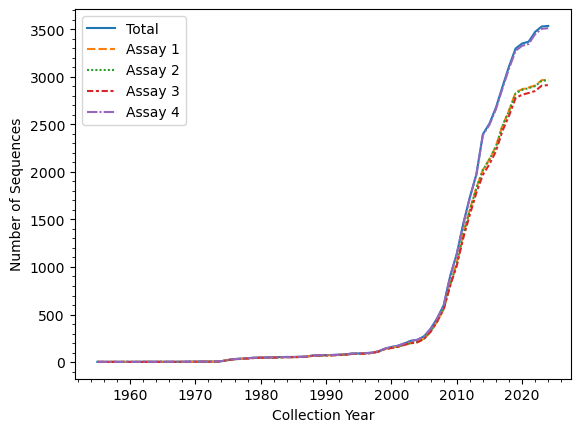

In [9]:
# Plot collection data 
sns.lineplot(data=combined, dashes=True)
plt.minorticks_on()
plt.ylabel('Number of Sequences');
plt.savefig('timeplot.svg', dpi=300, bbox_inches='tight')
# plt.title('Cumulative EV Sequences')

Text(0, 0.5, 'Number of Sequences')

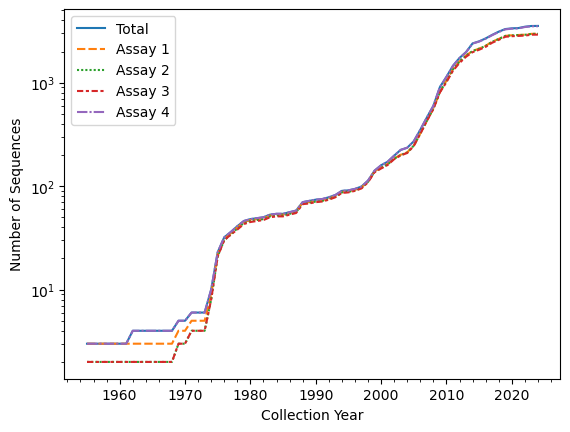

In [10]:
# Plot collection data (log scale)
sns.lineplot(data=combined, dashes=True)
plt.minorticks_on()
plt.yscale('log')
plt.ylabel('Number of Sequences')
# plt.title('Cumulative EV Sequences')

Heatmap for all assays 

In [11]:
# Generate heatmap total, ratio data for each assay (wide)
data = []

for assay in assays:
    # Get cumulative counts for each (species) group over collection year 
    aggregated = aggregate_counts(assay, years, collapse_info)
    
    # Reorder y-axis (optional)
    if virus_order:
        aggregated = aggregated.reindex(virus_order)
        
    data.append(calc_totals_ratios(aggregated))

In [12]:
data

[(                         2000   2005   2010    2015  2020  2024
  Virus Group                                                    
  Enterovirus A            17.0   48.0  268.0  1049.0  1490  1522
  Enterovirus B            40.0   51.0  138.0   254.0   420   468
  Enterovirus C            92.0  147.0  643.0   850.0   986  1007
  Enterovirus D            10.0   25.0   89.0   354.0   453   537
  Rhinovirus A              2.0    2.0   10.0    26.0    90   684
  Rhinovirus B              0.0    0.0    1.0     1.0    17   118
  Rhinovirus C              0.0    2.0   11.0    18.0    60   339
  unclassified Rhinovirus   0.0    0.0    0.0     0.0     1     1,
                           2000      2005      2010      2015      2020  \
  Virus Group                                                             
  Enterovirus A             1.0  1.000000  0.992537  0.993327  0.993960   
  Enterovirus B             1.0  0.980392  0.971014  0.948819  0.966667   
  Enterovirus C             1.0  1.0000

In [13]:
# Create long format data
long_data = []

for i, (total, ratio) in enumerate(data): 
    total = total.reset_index().melt(id_vars="Virus Group", var_name="Year", value_name="Total")
    ratio = ratio.reset_index().melt(id_vars="Virus Group", var_name="Year", value_name="Ratio")
    
    df = pd.merge(total, ratio, on=["Virus Group", "Year"])
    df['Assay'] = i + 1
    
    long_data.append(df)
    
final_df = pd.concat(long_data, ignore_index=True)

In [14]:
final_df

Virus Group  Year  Total     Ratio  Assay
0              Enterovirus A  2000   17.0  1.000000      1
1              Enterovirus B  2000   40.0  1.000000      1
2              Enterovirus C  2000   92.0  1.000000      1
3              Enterovirus D  2000   10.0  0.200000      1
4               Rhinovirus A  2000    2.0  0.000000      1
..                       ...   ...    ...       ...    ...
187            Enterovirus D  2024  537.0  1.000000      4
188             Rhinovirus A  2024  684.0  0.230994      4
189             Rhinovirus B  2024  118.0  0.042373      4
190             Rhinovirus C  2024  339.0  0.191740      4
191  unclassified Rhinovirus  2024    1.0  0.000000      4

[192 rows x 5 columns]

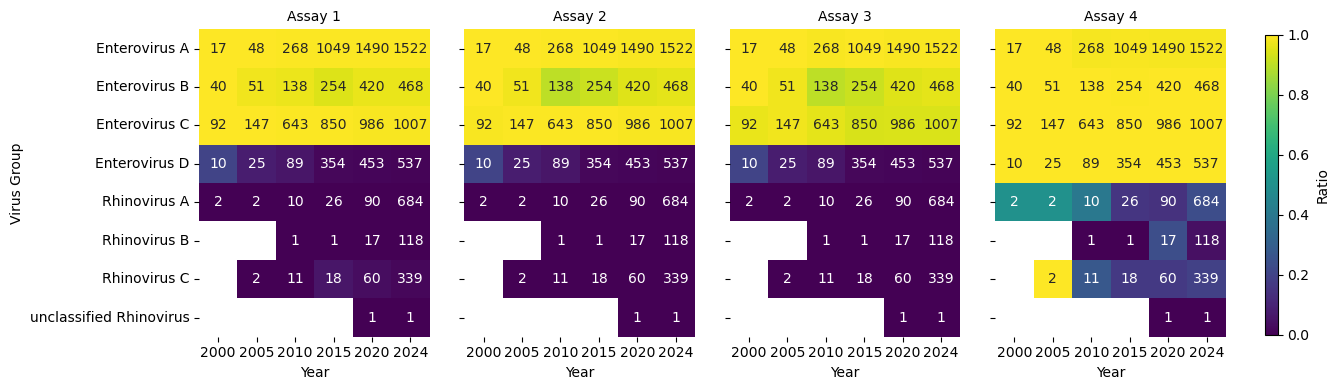

In [15]:
# Plot data on heatmap subplots 

def heatmap(data, **kwargs):
    pivot_ratio = data.pivot(index="Virus Group", columns="Year", values="Ratio")
    pivot_total = data.pivot(index="Virus Group", columns="Year", values="Total")
    
    ax = sns.heatmap(pivot_ratio, annot=pivot_total, fmt=".0f", cmap="viridis", cbar=False, vmin=0, vmax=1, square=True, **kwargs)
    
    return ax

g = sns.FacetGrid(final_df, col="Assay", height=4, aspect=.8)
g.map_dataframe(heatmap)

# Set up legend
cbar_ax = g.fig.add_axes([1, .15, .01, .75]) 
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
g.fig.colorbar(sm, cax=cbar_ax, label='Ratio')

# Edit subplot titles
g.set_titles("Assay {col_name}")

plt.savefig('heatmap.svg', dpi=300, bbox_inches='tight')
plt.show()